# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from matplotlib.image import imread
from IPython.display import display, Image as IPImage
import shutil
import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.utils import image_dataset_from_directory

2023-12-06 12:29:29.623694: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 12:29:29.625737: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-06 12:29:29.655672: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 12:29:29.655709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 12:29:29.657290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
csv_path = os.path.join(parent_directory, "raw_data/computer_vision/pokemon.csv")
df = pd.read_csv(csv_path)


In [3]:
images_directory = os.path.join(parent_directory, "raw_data/computer_vision/images/")


# Exploration

In [4]:
df.head()


,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [5]:
images_directory


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/images/'

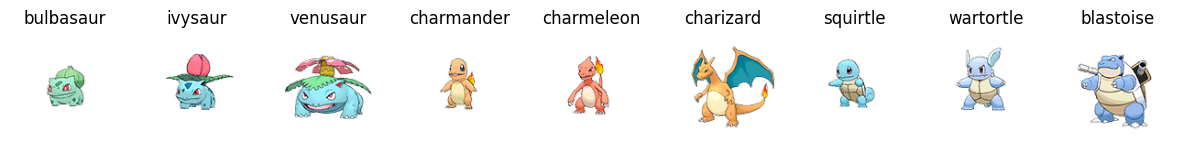

In [6]:
fig, axes = plt.subplots(1, 9, figsize=(15, 5))

for i, nom_pokemon in enumerate(df['Name'].head(9)):
    chemin_image_png = images_directory + nom_pokemon.lower() + ".png"
    chemin_image_jpg = images_directory + nom_pokemon.lower() + ".jpg"

    if os.path.exists(chemin_image_png):
        chemin_image = chemin_image_png
    elif os.path.exists(chemin_image_jpg):
        chemin_image = chemin_image_jpg
    else:
        print(f"Aucun fichier trouvé pour {nom_pokemon}")
        continue

    img = Image.open(chemin_image)

    axes[i].imshow(img)
    axes[i].set_title(nom_pokemon)
    axes[i].axis('off')

plt.show()


# Import OHE

In [7]:
df

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


In [8]:
df = df.copy()
df = df.fillna('')
df

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,
4,charmeleon,Fire,
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,
807,meltan,Steel,


In [9]:
X = df['Type1']

In [10]:
# Use column transform for preprocessing only type1 and type2
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, drop='first'), ['Type1', 'Type2'])
    ],
    remainder='passthrough'
)

In [11]:
# Use a pipelin for look perfectly the step
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['Type1', 'Type2'])]))])

In [12]:
# Apply the ohe
df_ohe = pipeline.fit_transform(df[['Type1', 'Type2']])

/home/morgane/.pyenv/versions/3.10.6/envs/catchemall/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
feature_names_out = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(['Type1', 'Type2'])

In [14]:
onehot_df = pd.DataFrame(df_ohe, columns=feature_names_out)

In [15]:
onehot_df

,Type1_Dark,Type1_Dragon,Type1_Electric,Type1_Fairy,Type1_Fighting,Type1_Fire,Type1_Flying,Type1_Ghost,Type1_Grass,Type1_Ground,...,Type2_Ghost,Type2_Grass,Type2_Ground,Type2_Ice,Type2_Normal,Type2_Poison,Type2_Psychic,Type2_Rock,Type2_Steel,Type2_Water
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
805,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Delet the prefixe Type_1 and Type_2 for every columns

for col in onehot_df.columns:
    if col.startswith('Type1_'):
        onehot_df.rename(columns={col: col.replace('Type1_', '')}, inplace=True)
    elif col.startswith('Type2_'):
        onehot_df.rename(columns={col: col.replace('Type2_', '')}, inplace=True)
onehot_df

,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,...,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
805,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
merged_df = onehot_df.groupby(level=0, axis=1).sum()

In [18]:
df_ohe = pd.concat([df, merged_df], axis=1)

In [19]:
df_ohe = df_ohe.drop(['Type1', 'Type2'], axis=1)

In [20]:
df_ohe

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,bulbasaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,ivysaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,venusaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,charmander,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,charmeleon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,stakataka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
805,blacephalon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,zeraora,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,meltan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Création dossiers par type de Pokémon

In [21]:
types = set(df['Type1'])
types


{'Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water'}

In [22]:
parent_directory


'/home/morgane/code/mtthibault/catchemall'

In [23]:
types_directory = os.path.join(parent_directory, "raw_data/computer_vision/types/")
types_directory


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types/'

In [24]:
for pokemon_type in types:
    type_directory_path = os.path.join(types_directory, pokemon_type)
    # Pour vérifier si dossier existe déjà, sinon créer
    if not os.path.exists(type_directory_path):
        os.makedirs(type_directory_path)


# Rangement des pokémons par dossier Type

In [25]:
for index, row in df.iterrows():
    pokemon_name = row['Name']
    type1 = row['Type1']
    type2 = str(row['Type2'])  # str pcq sinon ça bug à cause des NaN

    type1_directory_path = os.path.join(types_directory, type1)
    if os.path.exists(type1_directory_path):
        for ext in ['jpg', 'png']:
            source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
            if os.path.exists(source_image_path):
                destination_path = os.path.join(type1_directory_path, f'{pokemon_name}.{ext}')
                shutil.copy(source_image_path, destination_path)
                break

    # Vérifier si le type 2 existe et copier l'image
    if type2:
        type2_directory_path = os.path.join(types_directory, type2)
        if os.path.exists(type2_directory_path):
            for ext in ['jpg', 'png']:
                source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
                if os.path.exists(source_image_path):
                    destination_path = os.path.join(type2_directory_path, f'{pokemon_name}.{ext}')
                    shutil.copy(source_image_path, destination_path)
                    break


# Exploration 2

In [26]:
types_path = '/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'
types_path


'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'

In [27]:
pokemon_dict = {}


In [28]:
os.listdir(types_path)


['Ghost',
 'Fighting',
 'Ground',
 'Dark',
 'Flying',
 'Normal',
 'Steel',
 'Grass',
 'Ice',
 'Rock',
 'Water',
 'Electric',
 'Psychic',
 'Bug',
 'Fairy',
 'Fire',
 'Poison',
 'Dragon']

In [29]:
for type_folder in os.listdir(types_path):
    type_folder_path = os.path.join(types_path, type_folder) #donc là j'ai le chemin pour chaqun de mes folders TYPE

    # vérifie si le chemin est un dossier
    if os.path.isdir(type_folder_path):
        pokemon_names = [] # Jstock les noms des pokémons pour le type actuel

        # parcours de chaque image dans le dossier du type actuel
        for file_name in os.listdir(type_folder_path):
            # pour gérer png jpg
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                pokemon_name = os.path.splitext(file_name)[0] #pour split l'extension .png .jpg cimer chatgpt
                pokemon_names.append(pokemon_name) #J'ajoute le nom du pokémon à la liste

        pokemon_dict[type_folder] = pokemon_names


In [30]:
pokemon_dict


{'Ghost': ['golett',
  'aegislash-blade',
  'frillish',
  'sandygast',
  'duskull',
  'golurk',
  'decidueye',
  'gengar',
  'gastly',
  'palossand',
  'gourgeist-average',
  'froslass',
  'hoopa-confined',
  'shedinja',
  'shuppet',
  'haunter',
  'yamask',
  'chandelure',
  'rotom',
  'jellicent',
  'dhelmise',
  'honedge',
  'marshadow',
  'mismagius',
  'dusclops',
  'blacephalon',
  'misdreavus',
  'trevenant',
  'litwick',
  'giratina-altered',
  'dusknoir',
  'lampent',
  'doublade',
  'banette',
  'sableye',
  'phantump',
  'pumpkaboo-average',
  'cofagrigus',
  'drifloon',
  'lunala',
  'spiritomb',
  'drifblim',
  'mimikyu'],
 'Fighting': ['hitmonchan',
  'mankey',
  'stufful',
  'infernape',
  'hariyama',
  'gurdurr',
  'pancham',
  'combusken',
  'keldeo-ordinary',
  'mienshao',
  'crabrawler',
  'pheromosa',
  'blaziken',
  'mienfoo',
  'throh',
  'hitmonlee',
  'kommo-o',
  'hawlucha',
  'pignite',
  'conkeldurr',
  'marshadow',
  'lucario',
  'timburr',
  'crabominable',

In [31]:
len(pokemon_dict['Bug'])


77

In [32]:
pokemon_names


['axew',
 'salamence',
 'guzzlord',
 'shelgon',
 'goodra',
 'dragonite',
 'haxorus',
 'kingdra',
 'druddigon',
 'goomy',
 'vibrava',
 'sliggoo',
 'flygon',
 'zekrom',
 'tyrunt',
 'drampa',
 'noibat',
 'dragonair',
 'dialga',
 'gible',
 'noivern',
 'kommo-o',
 'gabite',
 'zweilous',
 'jangmo-o',
 'naganadel',
 'latias',
 'hydreigon',
 'fraxure',
 'latios',
 'rayquaza',
 'hakamo-o',
 'deino',
 'kyurem',
 'dragalge',
 'giratina-altered',
 'dratini',
 'reshiram',
 'altaria',
 'palkia',
 'tyrantrum',
 'zygarde-50',
 'turtonator',
 'garchomp',
 'bagon']

Type: Ghost


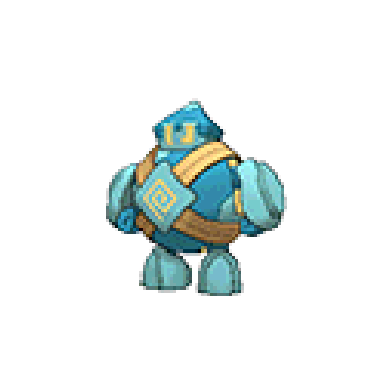

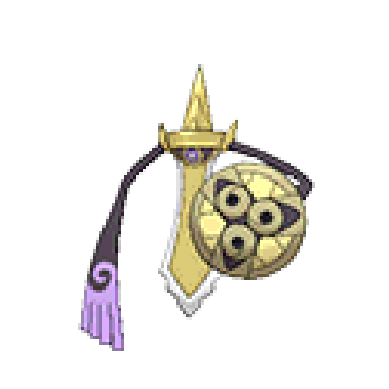

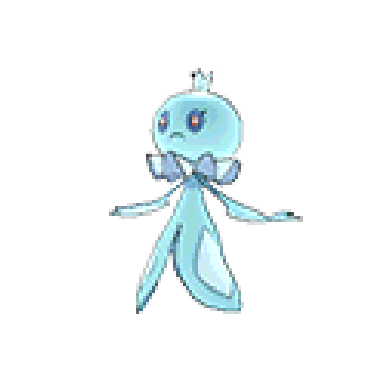



Type: Fighting


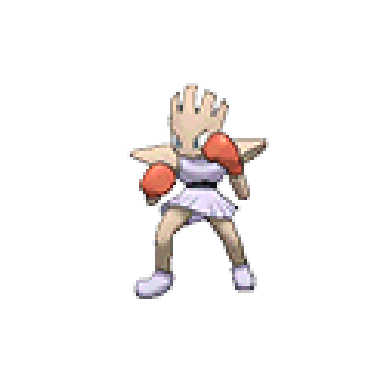

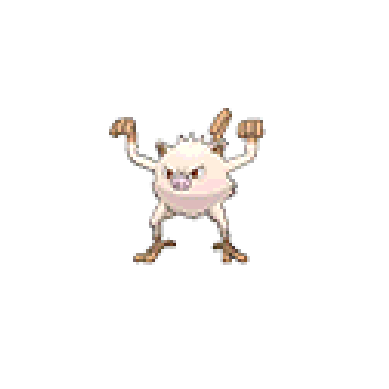

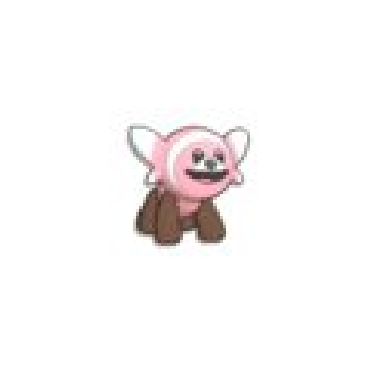



Type: Ground


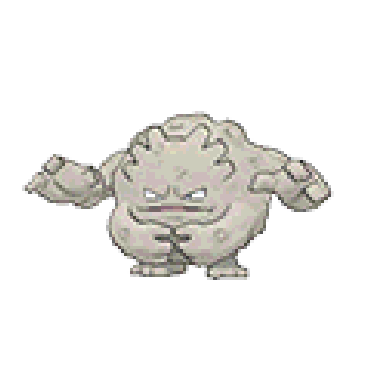

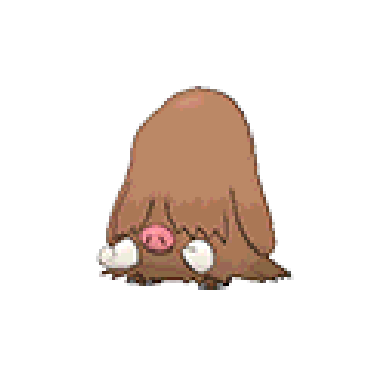

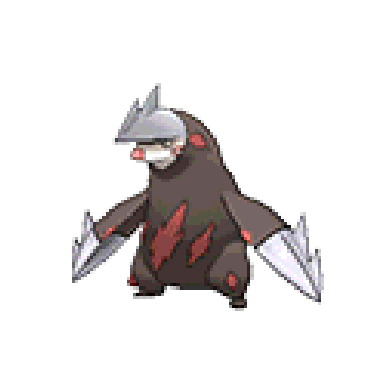



Type: Dark


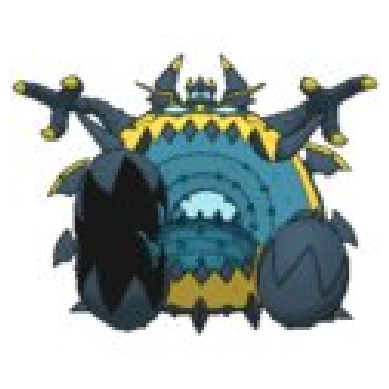

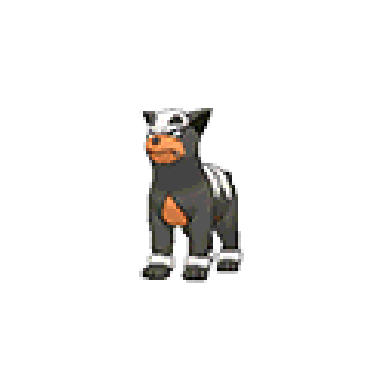

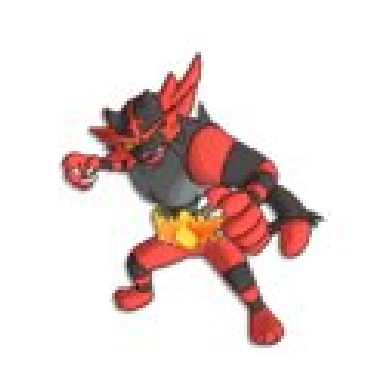



Type: Flying


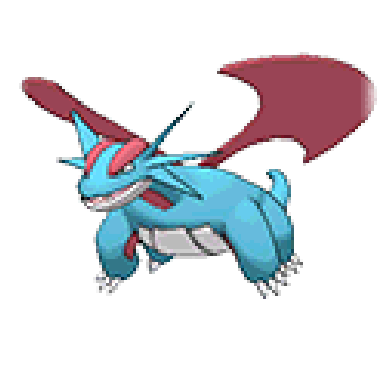

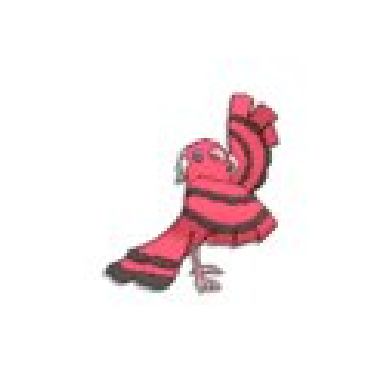

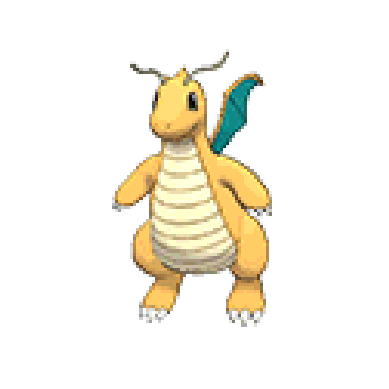



Type: Normal


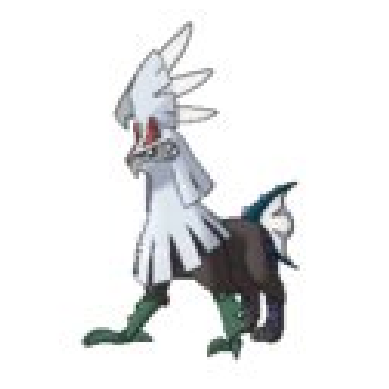

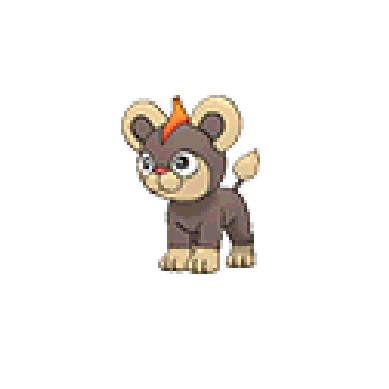

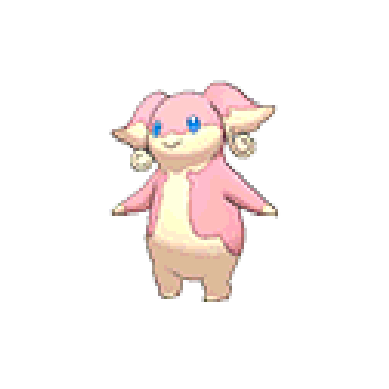



Type: Steel


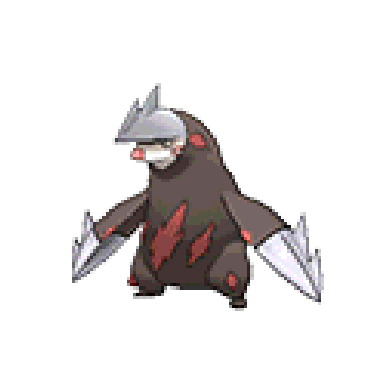

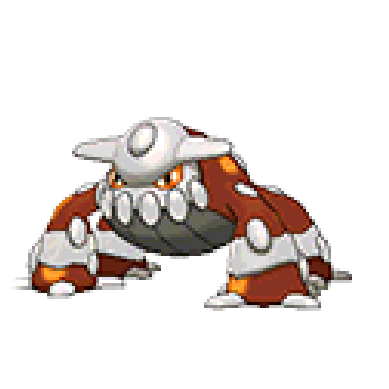

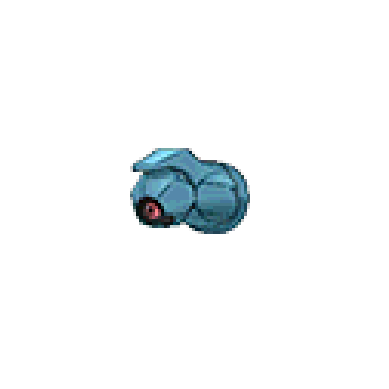



Type: Grass


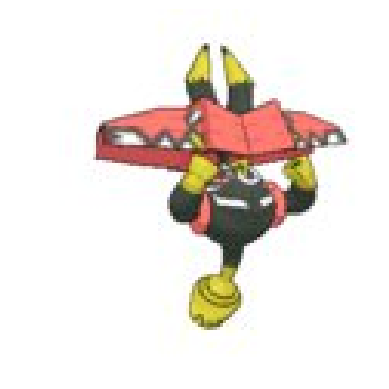

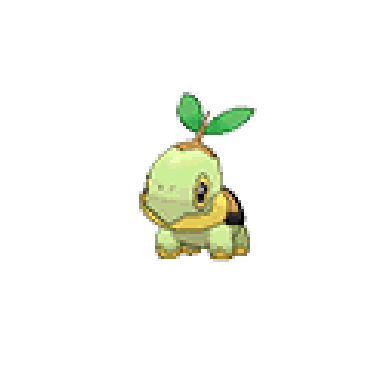

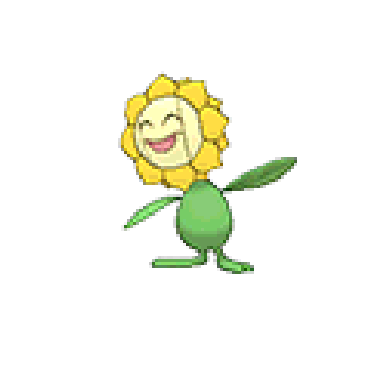



Type: Ice


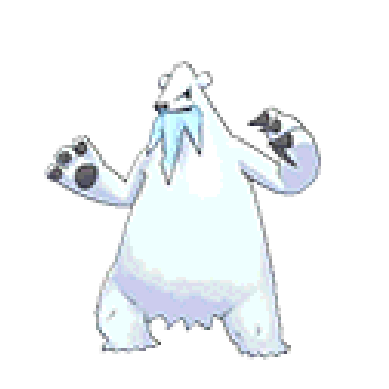

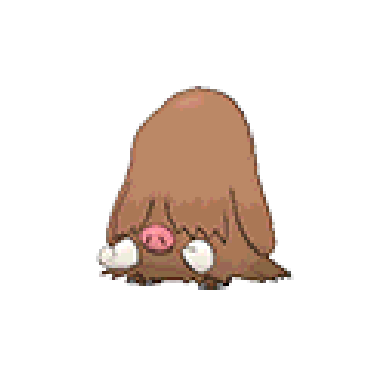

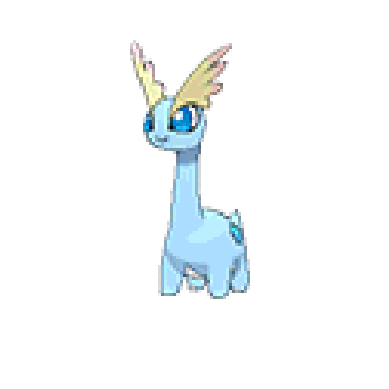



Type: Rock


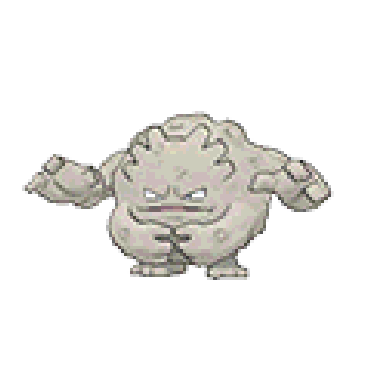

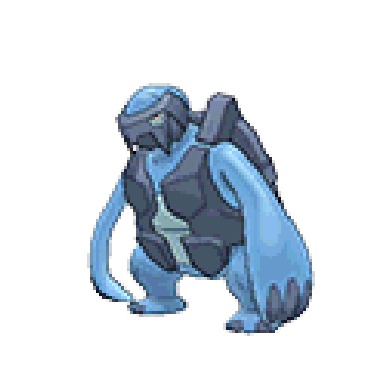

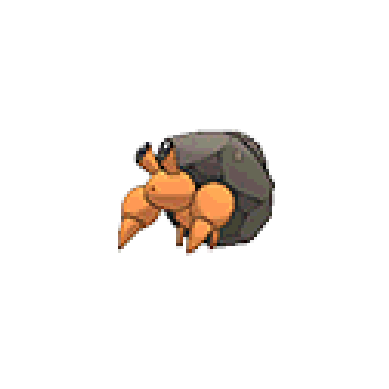



Type: Water


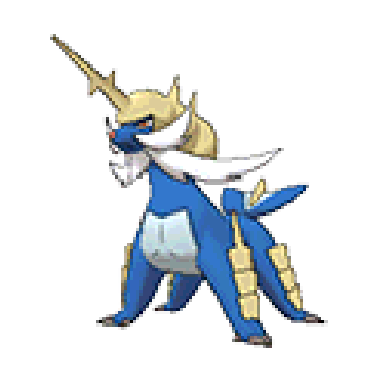

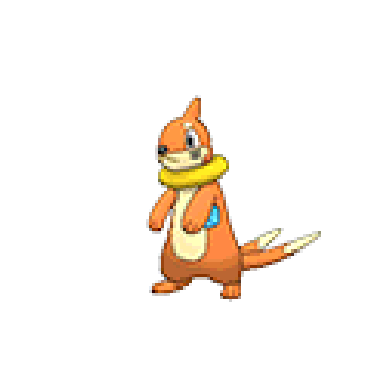

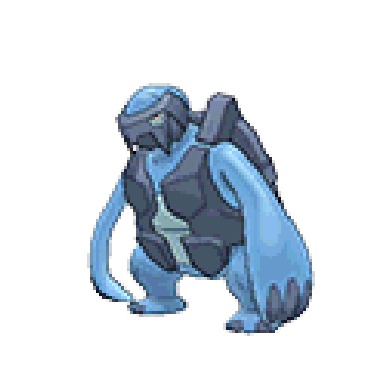



Type: Electric


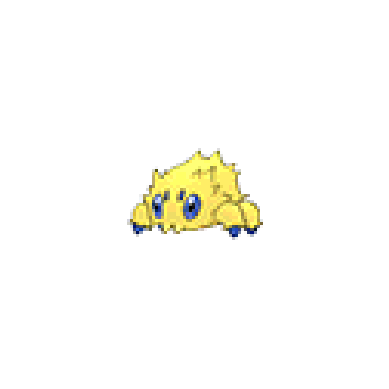

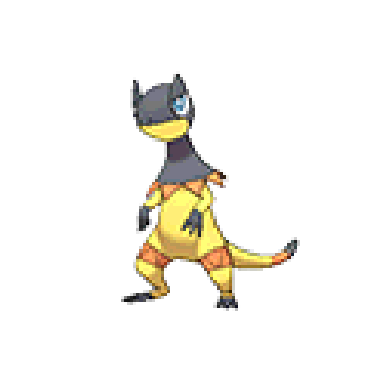

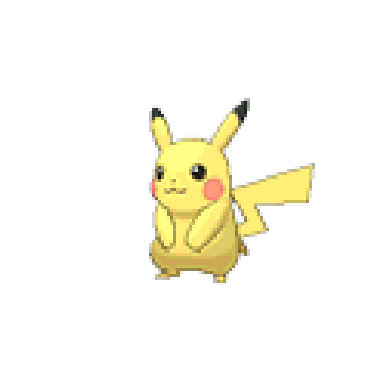



Type: Psychic


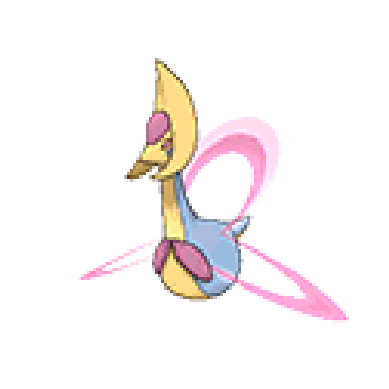

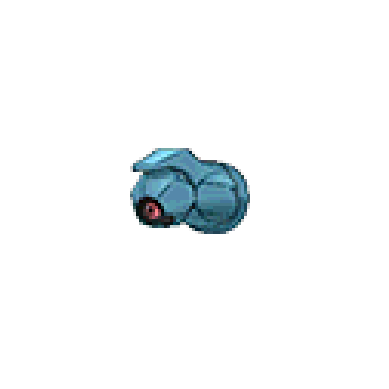

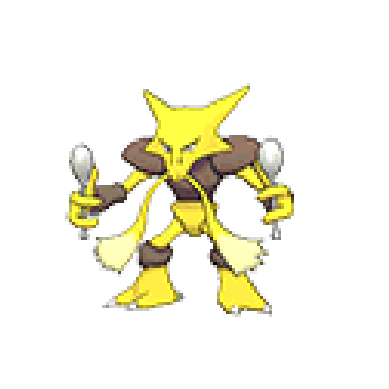



Type: Bug


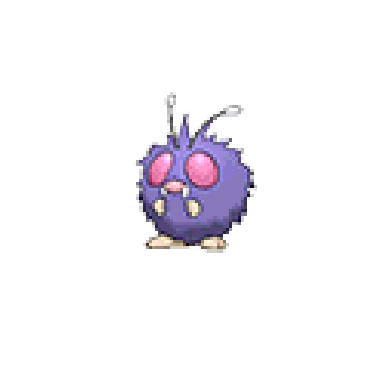

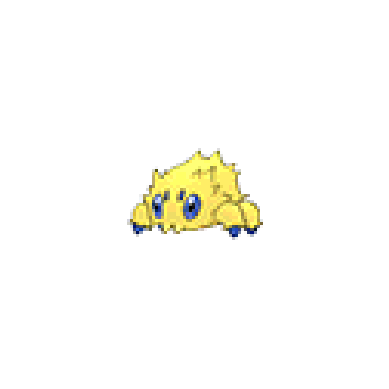

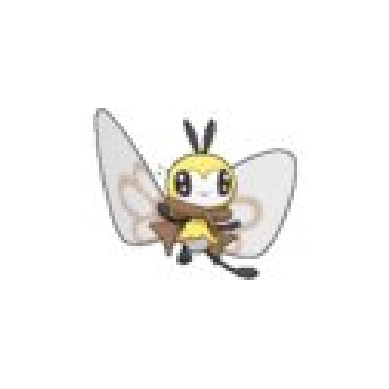



Type: Fairy


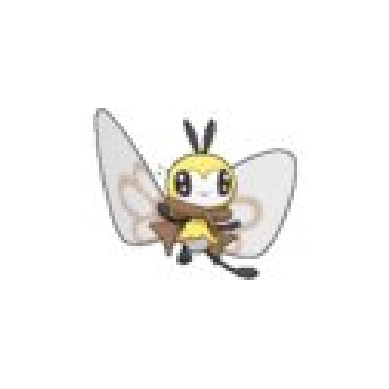

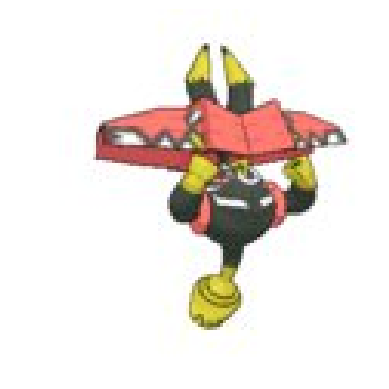

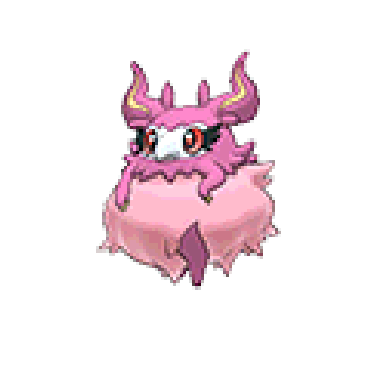



Type: Fire


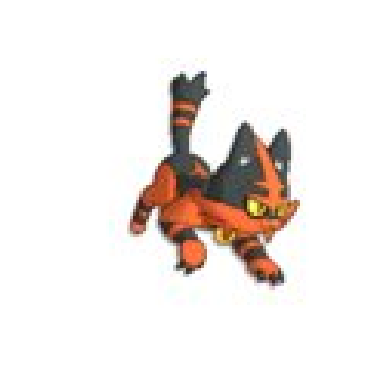

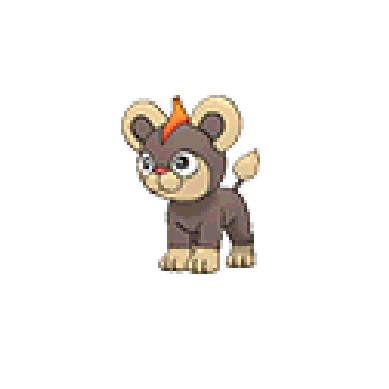

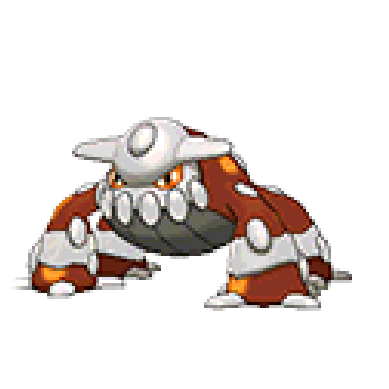



Type: Poison


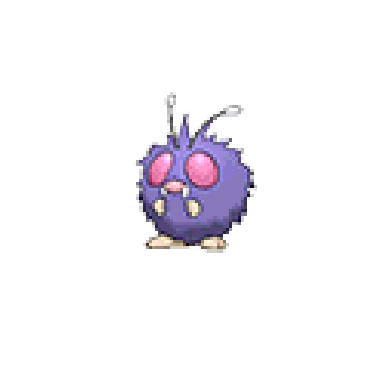

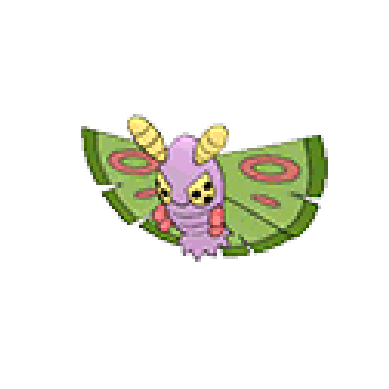

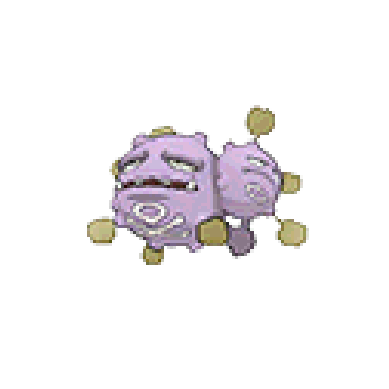



Type: Dragon


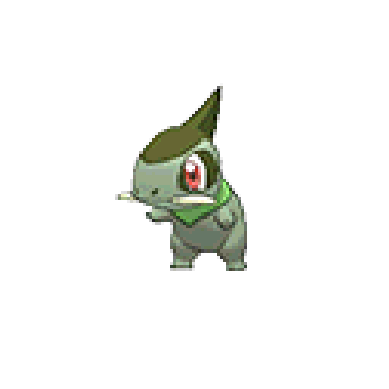

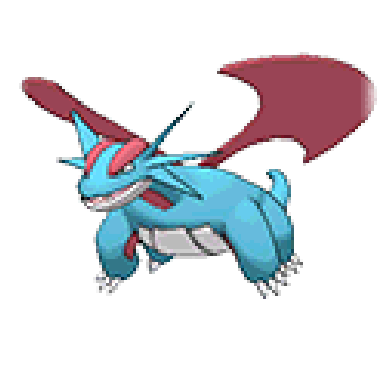

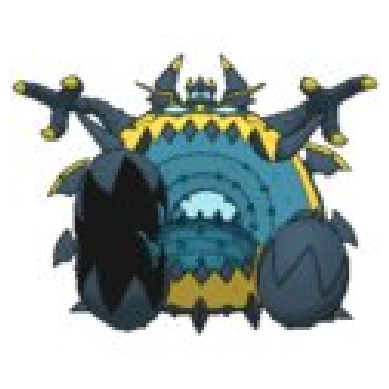

In [33]:
num_images_to_display = 3

for pokemon_type, pokemon_names in pokemon_dict.items():
    print(f"Type: {pokemon_type}")
    
    for name in pokemon_names[:num_images_to_display]:
        for extension in ['.jpg', '.jpeg', '.png']:
            image_path = os.path.join(types_path, pokemon_type, f"{name}{extension}")
            
            if os.path.exists(image_path):
                img = imread(image_path)
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                break
    
    print("\n")

Type: Ghost


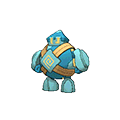

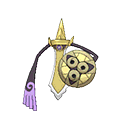

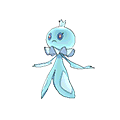



Type: Fighting


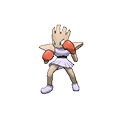

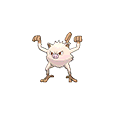

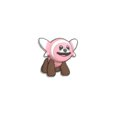



Type: Ground


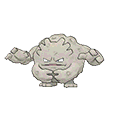

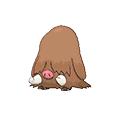

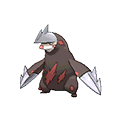



Type: Dark


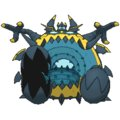

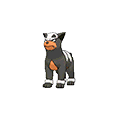

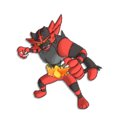



Type: Flying


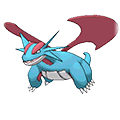

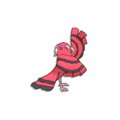

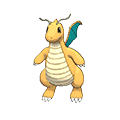



Type: Normal


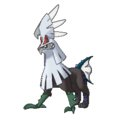

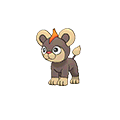

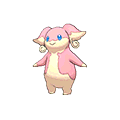



Type: Steel


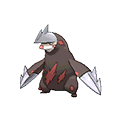

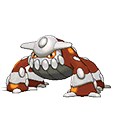

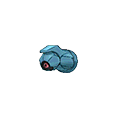



Type: Grass


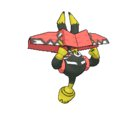

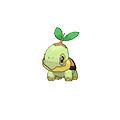

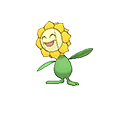



Type: Ice


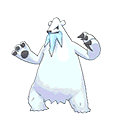

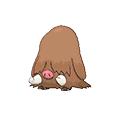

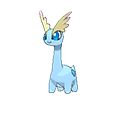



Type: Rock


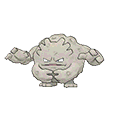

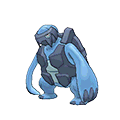

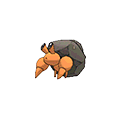



Type: Water


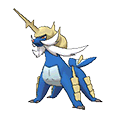

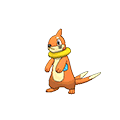

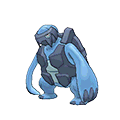



Type: Electric


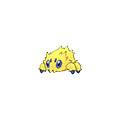

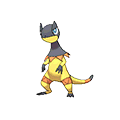

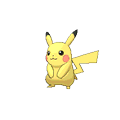



Type: Psychic


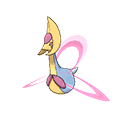

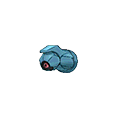

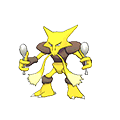



Type: Bug


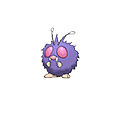

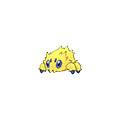

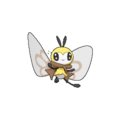



Type: Fairy


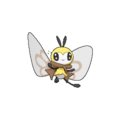

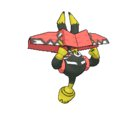

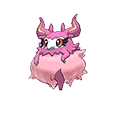



Type: Fire


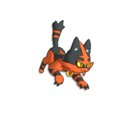

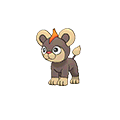

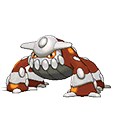



Type: Poison


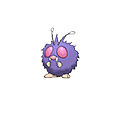

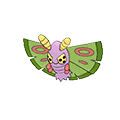

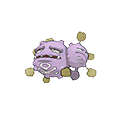



Type: Dragon


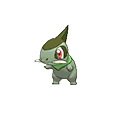

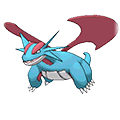

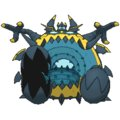

In [34]:
num_images_to_display = 3

for pokemon_type, pokemon_names in pokemon_dict.items():
    print(f"Type: {pokemon_type}")
    
    for name in pokemon_names[:num_images_to_display]:
        for extension in ['.jpg', '.jpeg', '.png']:
            image_path = os.path.join(types_path, pokemon_type, f"{name}{extension}")
            
            if os.path.exists(image_path):
                display(IPImage(filename=image_path))
                break
    
    print("\n")

# Analyse

In [35]:
y = list(df['Type1'].unique())
y

['Grass',
 'Fire',
 'Water',
 'Bug',
 'Normal',
 'Poison',
 'Electric',
 'Ground',
 'Fairy',
 'Fighting',
 'Psychic',
 'Rock',
 'Ghost',
 'Ice',
 'Dragon',
 'Dark',
 'Steel',
 'Flying']

In [36]:
types_path

'/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/types'

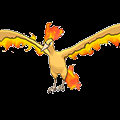

In [37]:
img = load_img(f"{types_path}/Fire/moltres.png")
img

In [38]:
x = img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [39]:
x.shape

(120, 120, 3)

# CNN

## First Model

In [40]:
#adam_opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

In [41]:
def first_model():
    
    ##########################
    # 1 - Architecture       #
    ##########################
    
    # Instantiate the Sequential model
    model = models.Sequential()
    
    # Rescaling layer
    model.add(layers.Rescaling(1./255, input_shape=(120,120,3)))
    
    # Convolutional Layers
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding = "same")) #pour spatial data (images)
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding = "same")) #goodpractice askip
    
    model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding = "same")) #pour spatial data (images)
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding = "same")) #goodpractice askip

    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding = "same")) #pour spatial data (images)
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding = "same")) #goodpractice askip

    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding = "same")) #pour spatial data (images)
    model.add(layers.MaxPooling2D(pool_size=(2,2), padding = "same")) #goodpractice askip
              
    model.add(layers.Flatten()) #pour passer de convolutional à dense layers         
              
    # Hidden Dense Layers
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(rate=0.5))  #pour régulariser modèle et éviter overfitting => potentiellement à ajuster       
    
    # Predictive layer
    model.add(layers.Dense(18, activation="softmax")) #softmax pcq 18 classes (sigmoid = binaire)
    
    ##########################
    # 2 - Compile            #
    ##########################
    
    model.compile(loss="categorical_crossentropy", #pcq plsrs valeurs qui sont OHE, sinon pour les entiers => sparse_categorical_crossentropy
                  optimizer="adam",
                  metrics = ["accuracy"])
    
    return model

In [42]:
first_model = first_model()
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1

2023-12-06 12:29:33.097473: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 12:29:33.097736: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Evaluation